### Introduction and Motivation

For our ENSF 612 project, we trained various models to predict the total ride duration of taxi trips in New York City (NYC). We chose to study this dataset because it offered insights into traffic patterns in one of the world's fastest-moving cities.

Our dataset was sourced from [Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data?select=train.zip). The dataset was cleaned specifically for a competition, enabling our group to concentrate on exploratory data analysis (EDA) and model building.

In this notebook, we train a `DecisionTree` model on the cleaned dataset.

### Setup drive

In [ ]:
# connect to collab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# record time
import time

# start record
start = time.time()

Mounted at /content/drive


In [ ]:
# root directories
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/ENSF 612/project"

MEDIA_PATH = BASE_PATH  + "/media"
DATASET_PATH = BASE_PATH + "/dataset"

In [ ]:
# NYC dataset
TRAIN_DATASET = DATASET_PATH + "/" + "train_cleaned_clustered.csv"

In [ ]:
""" Global Variables """

MAX_DURATION = 7200  # Maximum trip duration in seconds
MIN_DURATION = 180   # Minimum trip duration in seconds
MAX_DISTANCE = 60.0  # Maximum distance in kilometers
MIN_DISTANCE = 1.5   # Minimum distance in kilometers

DAY_OF_WEEK_MAPPING = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

### Library imports

In [ ]:
# normal imports
import os
import requests
from IPython.display import Image

# for dataframes
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# geodesic
from geopy.distance import geodesic

# calculation
from math import radians, cos, sin, asin, sqrt

from graphviz import Digraph

### Setup Spark

In [ ]:
# Install Java Development Kit (required for Apache Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark (version 3.5.0) with Hadoop (version 3)
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xf spark-3.5.0-bin-hadoop3.tgz

# Install the findspark library (used to locate and initialize Apache Spark)
!pip install -q findspark

# Set up the required environment variables for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize findspark and import SparkSession
import findspark
findspark.init()

In [ ]:
# eda
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, dayofweek, hour, count, when, year, month, minute, quarter, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql import types as T

# machine learning
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LinearRegressionModel, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [ ]:
# Create a Spark session and context
spark = SparkSession.builder.master("local").appName("Colab").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

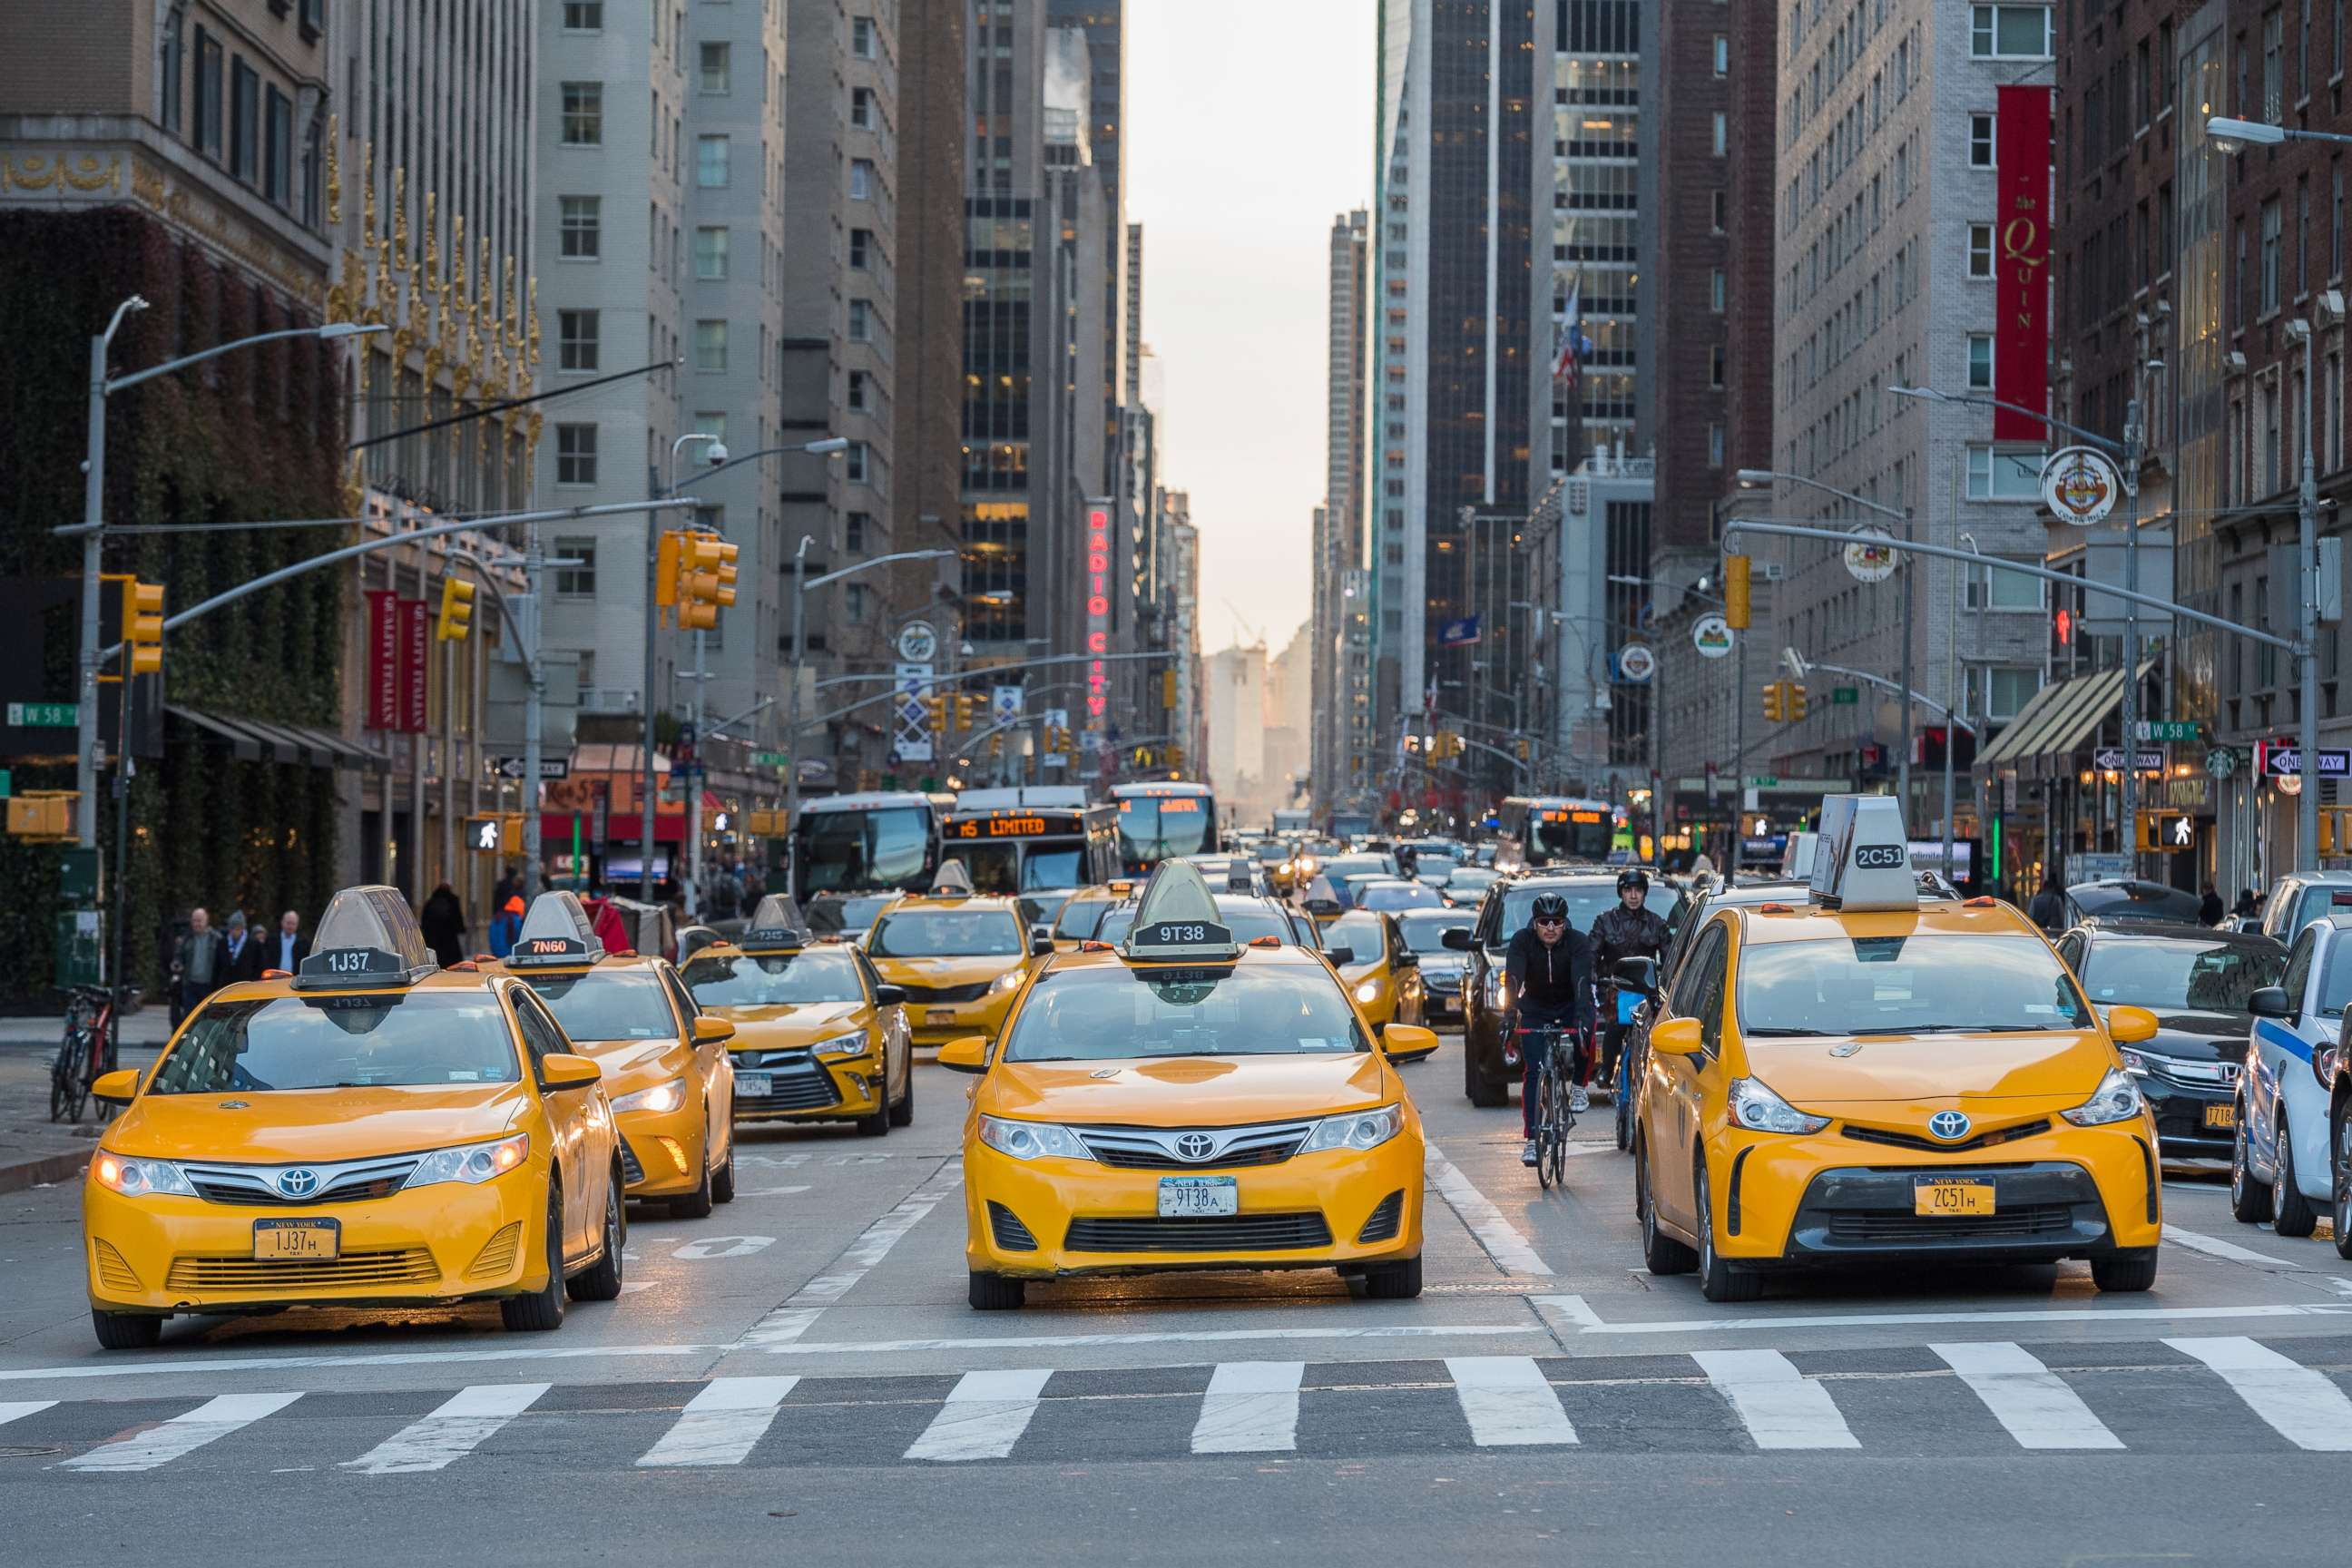

In [ ]:
nyc_image = MEDIA_PATH + "/nyc_image.jpg"
display(Image(filename=nyc_image))

### Read CSV

In [ ]:
spark = SparkSession.builder.appName("DecisionTrees").getOrCreate()

# Define the schema corresponding to the CSV file format
schema = StructType([
    StructField("trip_duration", FloatType(), True),
    StructField("distance", FloatType(), True),
    StructField("year", IntegerType(), True),
    StructField("quarter_of_year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("hour", IntegerType(), True),
    StructField("minute", IntegerType(), True),
    StructField("Sunday", IntegerType(), True),
    StructField("Monday", IntegerType(), True),
    StructField("Tuesday", IntegerType(), True),
    StructField("Wednesday", IntegerType(), True),
    StructField("Thursday", IntegerType(), True),
    StructField("Friday", IntegerType(), True),
    StructField("Saturday", IntegerType(), True),
    StructField("pickup_neighbourhood", IntegerType(), True),
    StructField("dropoff_neighbourhood", IntegerType(), True),
])

# Read the CSV file into a DataFrame
taxi_df = spark.read.csv(TRAIN_DATASET, schema=schema, header=True)
taxi_df.count()

961378

In [ ]:
# deep copy
taxi_df_final = taxi_df.select([col for col in taxi_df])

In [ ]:
taxi_df_final.show(5)

+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|pickup_neighbourhood|dropoff_neighbourhood|
+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|                  92|                  335|
|       2124.0|6.3850985|2016|              1|    1|  11|    35|     0|     0|      1|        0|       0|     0|       0|                 441|                  111|
|       1551.0|5.7149806|2016|              2|    5|   7|    54|     0|     0|      0|        0|       0|     0|       1|                  80|                  152|
|       12

In [ ]:
# split dataset
train_data, test_data = taxi_df_final.randomSplit([0.8, 0.2])

# define feature columns
feature_columns = [col for col in taxi_df_final.columns if col != "trip_duration"]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")

### Decision Tree (baseline)

Here, we built the initial `DecisionTree` model with the cleaned dataset.

In [ ]:
# decision Tree Model
dt = DecisionTreeRegressor(featuresCol="features_vec", labelCol="trip_duration")

In [ ]:
# create a pipeline
pipeline = Pipeline(stages=[assembler, dt])

In [ ]:
# train model
pipeline_model = pipeline.fit(train_data)

In [ ]:
# evaluate_model
predictions = pipeline_model.transform(test_data)

In [ ]:
# evaluate
evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_mse.evaluate(predictions)
print(f"R2: {r2}")
print(f"MSE: {rmse}")

R2: 0.614840635583639
MSE: 418.5931714228078


### Decision Tree (using pipeline)

We implemented a pipeline for hyper parameter tuning.

In [ ]:
# copy again to make sure its clean
taxi_df_final = taxi_df.select([col for col in taxi_df])

In [ ]:
# split the data into training and test sets
train_data, test_data = taxi_df_final.randomSplit([0.8, 0.2])

# define feature columns
feature_columns = [col for col in taxi_df_final.columns if col != "trip_duration"]

# create feature vectors using Assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")

In [ ]:
# define the model
dt = DecisionTreeRegressor(featuresCol="features_vec", labelCol="trip_duration")

# create pipeline
pipeline = Pipeline(stages=[assembler, dt])

# build the parameter grid for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 40, 50]) \
    .build()

# define the evaluator
evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")

# cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [ ]:
# fit the model
cvModel = crossval.fit(train_data)

In [ ]:
bestModel = cvModel.bestModel

# evaluate the best model
predictions = bestModel.transform(test_data)
r2 = evaluator.evaluate(predictions)
evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)

print(f"Best Model Parameters: {bestModel.stages[-1].extractParamMap()}")
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

Best Model Parameters: {Param(parent='DecisionTreeRegressor_1139fed1e63d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_1139fed1e63d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_1139fed1e63d', name='featuresCol', doc='features column name.'): 'features_vec', Param(parent='DecisionTreeRegressor_1139fed1e63d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: v

### Visualization

After hyper parameter tuning and model evaluation, we plotted the results.

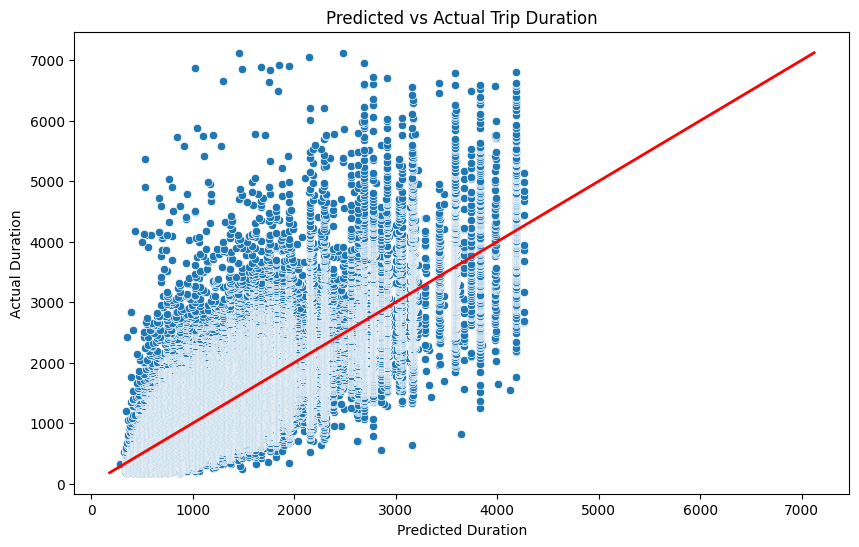

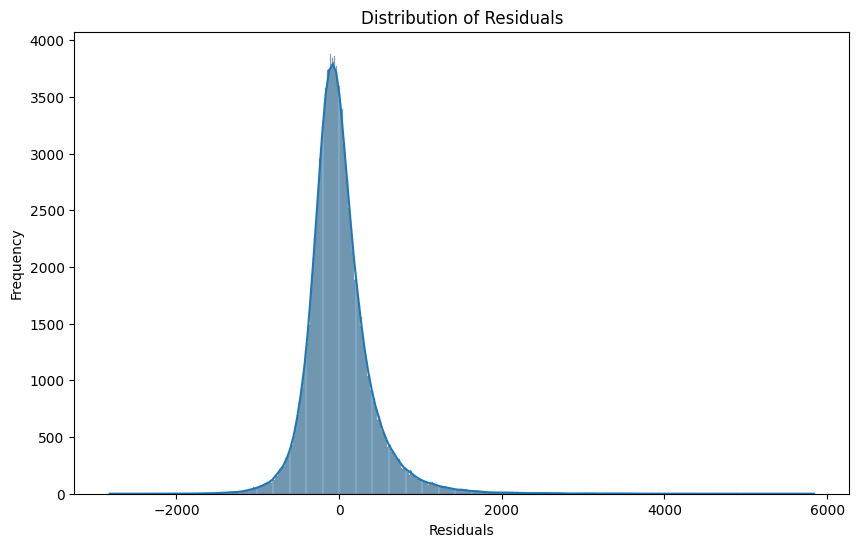

In [ ]:
# convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("prediction", "trip_duration").toPandas()

# plotting Prediction vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prediction', y='trip_duration', data=predictions_pd)
plt.plot([predictions_pd['trip_duration'].min(), predictions_pd['trip_duration'].max()],
         [predictions_pd['trip_duration'].min(), predictions_pd['trip_duration'].max()],
         color='red', lw=2)
plt.xlabel('Predicted Duration')
plt.ylabel('Actual Duration')
plt.title('Predicted vs Actual Trip Duration')
plt.show()

# plotting residuals
predictions_pd['residuals'] = predictions_pd['trip_duration'] - predictions_pd['prediction']
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

### End of notebook

In [ ]:
end = time.time()
delta_time = end - start
print(F"It took {delta_time} s to run the notebook.")

It took 1407.6115419864655 s to run the notebook.
